<a href="https://colab.research.google.com/github/RajidiSahithi/Session_10/blob/main/S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ERA_S10_COLAB


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ERA_S10_COLAB


In [2]:
%pip install albumentations==0.4.6
%pip install  torch_lr_finder
%pip install torch


In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
from modular.transforms import  get_a_train_transform,get_a_test_transform
from modular.dataloader import Cifar10SearchDataset,get_loader
batch_size = 512
use_cuda=True
train_loader, test_loader = get_loader(get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)


print(get_a_train_transform())

print(get_a_test_transform())

print(train_loader)
print('length of train_loader',len(train_loader))
print(test_loader)
print('length of test_loader',len(test_loader))



Files already downloaded and verified
Files already downloaded and verified
Compose([
  Normalize(always_apply=True, p=1.0, mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616), max_pixel_value=255.0),
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(-0.2, 0.2), scale_limit=(-0.19999999999999996, 0.19999999999999996), rotate_limit=(-15, 15), interpolation=1, border_mode=4, value=None, mask_value=None),
  PadIfNeeded(always_apply=False, p=1.0, min_height=36, min_width=36, border_mode=4, value=None, mask_value=None),
  RandomCrop(always_apply=False, p=1.0, height=32, width=32),
  CenterCrop(always_apply=False, p=1.0, height=32, width=32),
  CoarseDropout(always_apply=False, p=0.5, max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8),
  ToTensorV2(always_apply=True, p=1.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
Compose([
  Normalize(always_apply=True, p=1.0, mean=(0.4

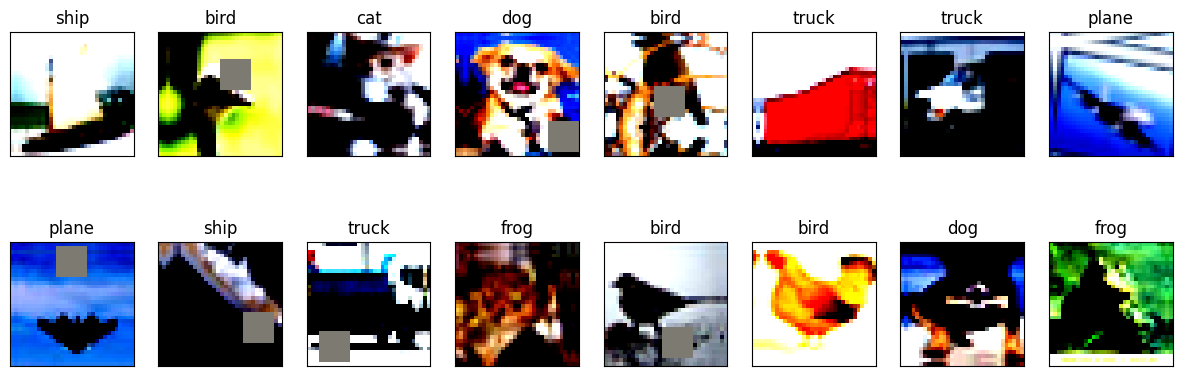

In [5]:
from modular.visualize import  print_samples

print_samples(train_loader)

In [6]:
batch = iter(train_loader)
images, labels = next(batch)
print(images.shape) # torch.Size([num_samples, in_channels, H, W])
print(labels.shape)

torch.Size([512, 3, 32, 32])
torch.Size([512])


In [7]:
%pip install torchsummary
from torchsummary import summary
from modular.CUSTOMRESNET import Net,model_summary
from modular.training import train_model,test_model
#from modular.utils import get_lr,denormalize

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [8]:
model

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv11): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (conv12): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (co

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.59E-03


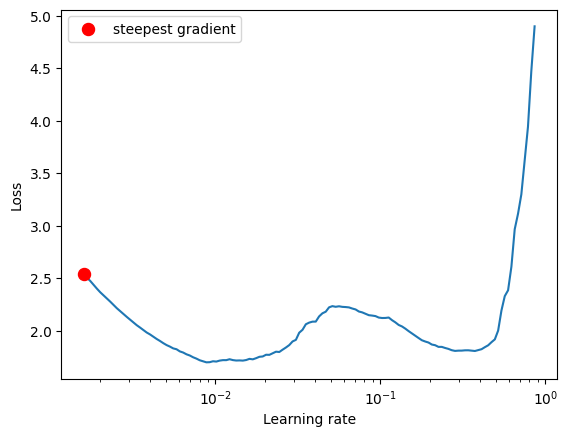

Min Loss = 1.70073820907161, Max LR = 0.008804883581643462


In [11]:

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from torch_lr_finder import LRFinder

model =  Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

min_loss = min(lr_finder.history["loss"])
max_lr = lr_finder.history["lr"][np.argmin(lr_finder.history["loss"], axis=0)]

print("Min Loss = {}, Max LR = {}".format(min_loss, max_lr))

    # Reset the model and optimizer to initial state
lr_finder.reset()



In [12]:
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR

learning_rate=[]
scheduler = OneCycleLR(
        optimizer,
        max_lr=1.59E-03,
        steps_per_epoch=1,
        epochs=26,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

EPOCHS = 24
for epoch in range(EPOCHS):
    scheduler.step()
    print("EPOCH:", epoch)
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
    train_model(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test_model(model, device, test_loader)

    learning_rate.append(param_group['lr']),



EPOCH: 0
lr=  0.0003723


Loss=1.1109507083892822 Batch_id=97 Accuracy=49.24: 100%|██████████| 98/98 [00:35<00:00,  2.72it/s]



Test set:  Accuracy: 5679/10000 (56.79%)

EPOCH: 1
lr=  0.0007287


Loss=0.8647873401641846 Batch_id=97 Accuracy=64.89: 100%|██████████| 98/98 [00:34<00:00,  2.81it/s]



Test set:  Accuracy: 7312/10000 (73.12%)

EPOCH: 2
lr=  0.0010850999999999999


Loss=0.8662615418434143 Batch_id=97 Accuracy=72.45: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set:  Accuracy: 7313/10000 (73.13%)

EPOCH: 3
lr=  0.0014414999999999999


Loss=0.6320058107376099 Batch_id=97 Accuracy=76.11: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set:  Accuracy: 7877/10000 (78.77%)

EPOCH: 4
lr=  0.0015449437773279353


Loss=0.5845252871513367 Batch_id=97 Accuracy=79.54: 100%|██████████| 98/98 [00:35<00:00,  2.78it/s]



Test set:  Accuracy: 8028/10000 (80.28%)

EPOCH: 5
lr=  0.0014677045384615386


Loss=0.5801482200622559 Batch_id=97 Accuracy=82.27: 100%|██████████| 98/98 [00:35<00:00,  2.80it/s]



Test set:  Accuracy: 8078/10000 (80.78%)

EPOCH: 6
lr=  0.0013904652995951417


Loss=0.45305952429771423 Batch_id=97 Accuracy=83.84: 100%|██████████| 98/98 [00:34<00:00,  2.80it/s]



Test set:  Accuracy: 8616/10000 (86.16%)

EPOCH: 7
lr=  0.001313226060728745


Loss=0.36993470788002014 Batch_id=97 Accuracy=85.62: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]



Test set:  Accuracy: 8342/10000 (83.42%)

EPOCH: 8
lr=  0.0012359868218623483


Loss=0.36582207679748535 Batch_id=97 Accuracy=86.78: 100%|██████████| 98/98 [00:34<00:00,  2.80it/s]



Test set:  Accuracy: 8730/10000 (87.30%)

EPOCH: 9
lr=  0.0011587475829959513


Loss=0.3040536046028137 Batch_id=97 Accuracy=88.13: 100%|██████████| 98/98 [00:34<00:00,  2.81it/s]



Test set:  Accuracy: 8489/10000 (84.89%)

EPOCH: 10
lr=  0.0010815083441295546


Loss=0.35869351029396057 Batch_id=97 Accuracy=88.50: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]



Test set:  Accuracy: 8822/10000 (88.22%)

EPOCH: 11
lr=  0.001004269105263158


Loss=0.3063914179801941 Batch_id=97 Accuracy=89.52: 100%|██████████| 98/98 [00:35<00:00,  2.77it/s]



Test set:  Accuracy: 8797/10000 (87.97%)

EPOCH: 12
lr=  0.0009270298663967612


Loss=0.2671511173248291 Batch_id=97 Accuracy=90.07: 100%|██████████| 98/98 [00:34<00:00,  2.82it/s]



Test set:  Accuracy: 8858/10000 (88.58%)

EPOCH: 13
lr=  0.0008497906275303645


Loss=0.3242798149585724 Batch_id=97 Accuracy=91.12: 100%|██████████| 98/98 [00:34<00:00,  2.85it/s]



Test set:  Accuracy: 8772/10000 (87.72%)

EPOCH: 14
lr=  0.0007725513886639677


Loss=0.25662508606910706 Batch_id=97 Accuracy=91.72: 100%|██████████| 98/98 [00:33<00:00,  2.89it/s]



Test set:  Accuracy: 8875/10000 (88.75%)

EPOCH: 15
lr=  0.000695312149797571


Loss=0.25481343269348145 Batch_id=97 Accuracy=92.14: 100%|██████████| 98/98 [00:33<00:00,  2.90it/s]



Test set:  Accuracy: 8739/10000 (87.39%)

EPOCH: 16
lr=  0.0006180729109311741


Loss=0.18919914960861206 Batch_id=97 Accuracy=92.56: 100%|██████████| 98/98 [00:35<00:00,  2.79it/s]



Test set:  Accuracy: 8978/10000 (89.78%)

EPOCH: 17
lr=  0.0005408336720647774


Loss=0.2174367904663086 Batch_id=97 Accuracy=93.10: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set:  Accuracy: 8932/10000 (89.32%)

EPOCH: 18
lr=  0.0004635944331983805


Loss=0.15855424106121063 Batch_id=97 Accuracy=93.99: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]



Test set:  Accuracy: 9063/10000 (90.63%)

EPOCH: 19
lr=  0.0003863551943319838


Loss=0.150477334856987 Batch_id=97 Accuracy=94.38: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]



Test set:  Accuracy: 9041/10000 (90.41%)

EPOCH: 20
lr=  0.00030911595546558707


Loss=0.14337743818759918 Batch_id=97 Accuracy=95.03: 100%|██████████| 98/98 [00:34<00:00,  2.83it/s]



Test set:  Accuracy: 9120/10000 (91.20%)

EPOCH: 21
lr=  0.00023187671659919036


Loss=0.16122034192085266 Batch_id=97 Accuracy=95.62: 100%|██████████| 98/98 [00:34<00:00,  2.82it/s]



Test set:  Accuracy: 9205/10000 (92.05%)

EPOCH: 22
lr=  0.00015463747773279365


Loss=0.07756074517965317 Batch_id=97 Accuracy=96.16: 100%|██████████| 98/98 [00:34<00:00,  2.86it/s]



Test set:  Accuracy: 9229/10000 (92.29%)

EPOCH: 23
lr=  7.739823886639672e-05


Loss=0.14669601619243622 Batch_id=97 Accuracy=96.50: 100%|██████████| 98/98 [00:33<00:00,  2.90it/s]



Test set:  Accuracy: 9267/10000 (92.67%)

